#Objective of the SCREAM Game
Design a risk mitigation strategy to minimize total supply chain costs or maximize total supply chain profits while also maximizing the order fill rate (Service Level) over an uncertain future.

The online simulator (SCREAM v4.0) was here : https://scxscream.herokuapp.com/home/ It is only open during the challenges.

##Overview
###About the Game
Each team will run its own Widget supply chain. This will consist of:
•  A Supplier: Recieves raw material (RM) and converts it to (WIP)
•  A Plant: Converts WIP to finished goods (FG)
•  A Distribution Center (DC): Stores FG for delivery to customers
A basic diagram of your supply chain is represented below.
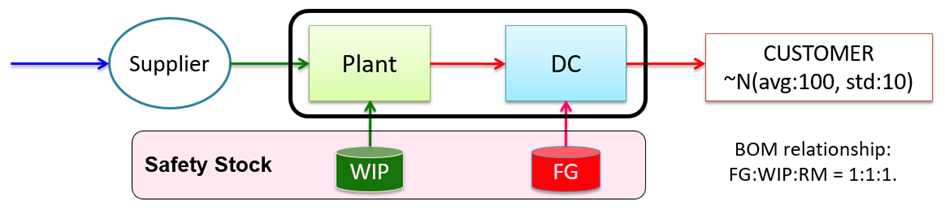
 
##What you Control
For this supply chain:
•  You have control over your Plant and your DC, but not your supplier
•  Standard inventory policies are already established at each facility and are very conservative
•  Standard inventory policies cannot be changed

##More Details
###Disruptions
Your supply chain can be subject to 3 different disruptions:
•  Supplier Disruptions
•  Manufacturing Disruptions
•  Distribution Disruptions
Each one of these disruptions can occur at any time and can last for one period all the way up to all periods. It is also possible that disruptions do not occur at all.
###Decisions
In order to mitigate these disruptions you are able to make 5 key decisions:
•  Set your Backup Inventory level for finished goods
•  Set your Backup Inventory level for work in progress
•  Choose a backup DC policy
•  Choose a backup Plant policy
•  Choose a backup Supplier policy
Is is important to note that your company will not activate a backup option when a facility goes down. When this happens, your company will wait until your backup inventory falls below [Facility Response Time] * [Mean Demand] before activating a backup option. This could save you from incurring setup costs if a facility is only down for a short time that your backup inventory can cover.

A diagram showing how these decisions play into your supply chain is represented below.
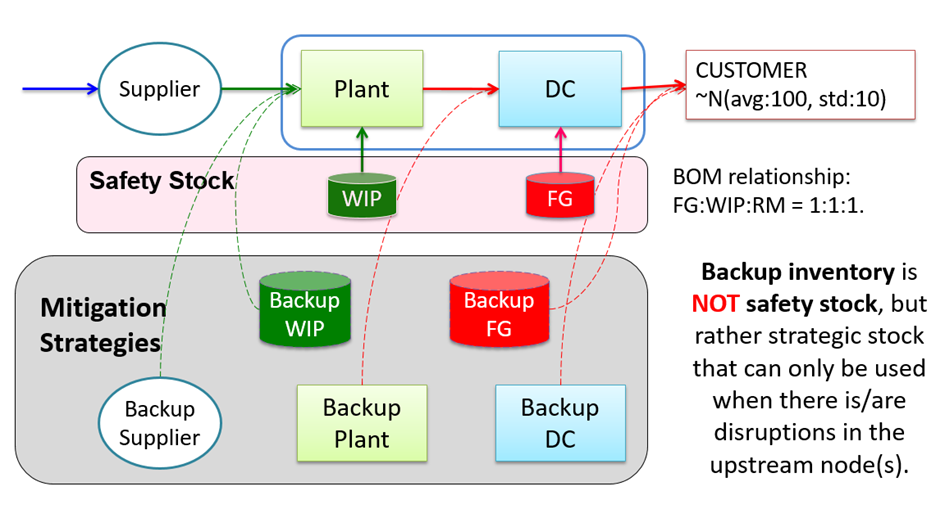
 
##How it works
Your decisions have specific impacts on how your company will deal with a disruption. Consider a situation where a disruption is possible at a DC. You set backup finished goods inventory and select a backup DC policy.

At the start of the simulated year, you pay the option cost for your DC policy selection. When a disruption hits, you attempt to use all of your backup inventory before making a decision to invoke your option and pay a setup cost. You will only invoke the option if you get to a point where you cannot cover demand with your backup inventory (given response time) before your backup facility can be operational. Once your backup facility is operational, you will pay an extra variable cost for each item that flows through the facility. Once the diruption has eneded, you close your backup facility and resume normal operations.

A diagram showing how this functions is represented below.
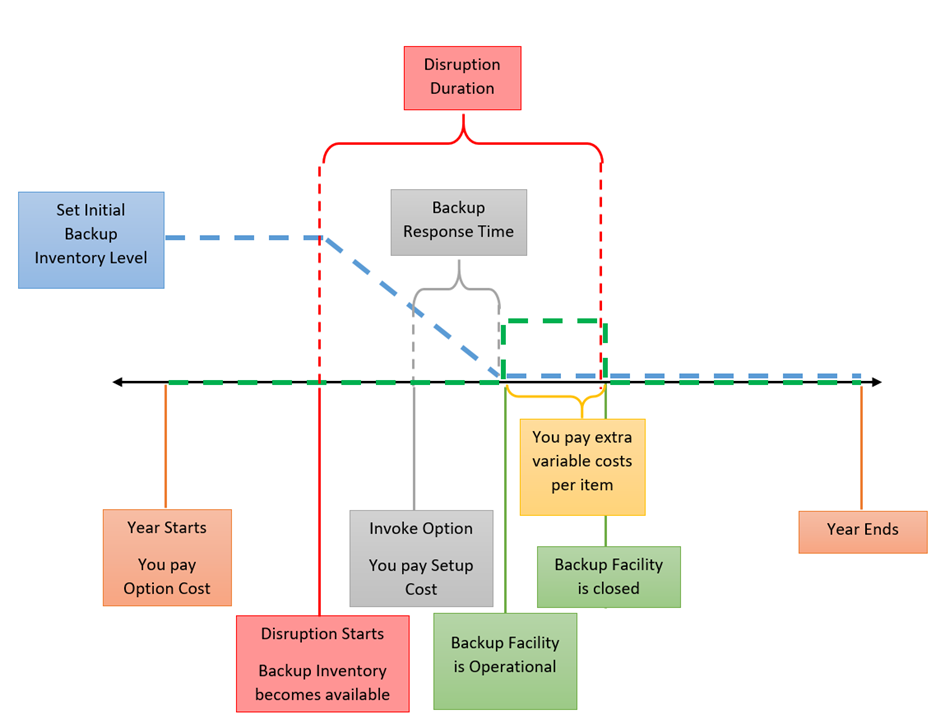

#Solution approach
##Overview
This is the first attempt to find the best solution for the MIT SCREAM challenge http://scxscream.herokuapp.com/home/ with Mixed Integer Linear Programming and the Google open source OR-TOOLS library.

This notebook showcases :
 - intensive use of OR-TOOLS library
 - how to test a complex MILP model

Unfortunately, it does not give the best answer. Indeed, I was extremely hard to modelize properly the behaviour of the online SCREAM simulator. There are few strange behaviours in the simulator like :
 - even with DC, Plant and Supplier closed for a year and with no backup, you still make profit !
 - when you buy backup FG inventory upfront you only pay the conversion costs \$20. You will pay \$50 more for the WIP once you use this backup FG. But you don't need to ensure how these WIP will be delivered to you. These WIP are there even if your supplier or plant are closed. I don't understand how one can accumulate a "conversion inventory".

Moreover, the score of SCXScream is calculated as if each scenario had the same probability of occurence. Here, with the present solution, we try to find the best solution for a combinaison of random scenarios based on their probability of occurence. 

See Scream version 2 for a more robust way to find the optimum input parameters according to the simulator expectation.

These limitations put aside, it's an interesting optimization problem. However, because SCREAM Simulator is a black box, MILP does not seem to be the best way to find the best solution. A better approach could be using Monte Carlo for generating various backup parameters and test scenarios and using the REST API (https://scxscream.herokuapp.com/tests/) to get the calculated profit and Item Fill Rate.

This work was inspired by https://github.com/JorgeGarciaCastillo/SCREAM/. It is a similar attempt done a few years ago. It is based on java and the IBM CPLEX opimization engine. 

## Problem analysis
The hard problem could be splitted into two questions :  
1) how do we estimate the risk probability for the various disruptions.
2) how do  we modelize the supply chain

For the first question, let's say,
 - we are 100% sure we will have full disruption of our DC each year. In that case, it is better to directly buy backup inventory of Finished Goods to cover our full yearly demand at the beginning of the year. We will endure holding cost but we are sure we will use this inventory.
 - but now, let's say we are only 20% sure our DC will fail each year. Are we going to buy a full year of backup FG and pay full holding cost even though we will not use it ? In that case, it may be worth paying an option for an additionnal DC.

Now let's say we have :
- 50% probability of no DC failure, 10% probability of 2 months DC failure, 5% probability 1 months DC failure
- 40% probability of no plant failure, 20% probability of 2 months Plant failure
What should be the optimal mix of WIP backup inventory, FG backup inventory, Supplier Backup Option, ...?

The question lies with how we estimate disruption probability risks of the supply chain of the proposed Use Case Textile Computation, Inc.
* The company is vertically-integrated => Good Control
* The supply chain is very simple => Low complexity
* Waco, Texas Factory has no union force => Lower risks of strike
* Texas : what are the risk probability disaster in Texas ? Here is a gold mine to help estimate this : https://hazards.fema.gov/nri/map. Dallas is "Relatively Moderate". One can find raw figures here https://hazards.fema.gov/nri/data-resources#csvDownload. We see that for county of McLennan (the one of the Waco Factory) that the "the number of occurrences per year of various hazard occurrence " are
  - Drought : 28 events/year
  - Earthquake : 0 events/year
  - Hail : 4 events/year
  - Landslide : 80 events/year
  - Strong Wind : 2 events/year
These figures relate to the entire county. So the probability and the level of disruption to apply to the factory of Waco should be adjusted accordingly.

Then, we keep on this analysis for the other parts of the supply chain.

Now, another challenge is how to convert these qualitative and statistics into a probability distribution of event occurences and durations ? Here is a excerpt of a few publications regarding this question :
 - [Natural_Disasters_Casualties_and_Power_Laws_A_Comparative_Analysis_with_Armed_Conflict](https://www.researchgate.net/publication/228576670_Natural_Disasters_Casualties_and_Power_Laws_A_Comparative_Analysis_with_Armed_Conflict)
 - [Ensemble Model Development for the Prediction of a Disaster Index in Water Treatment Systems](https://www.mdpi.com/2073-4441/12/11/3195)
 - https://public.wmo.int/en/resources/bulletin/quantifying-risk-disasters-occur-hazard-information-probabilistic-risk-assessment
 - [Fat Tailed Distributions for Deaths in Conflicts and Disasters](https://www.researchgate.net/publication/305983595_Fat_Tailed_Distributions_for_Deaths_in_Conflicts_and_Disasters)

These publications highlight the Power Law continous distribution to estimate the probability of disasters.
The discrete distribution matching the continuous Power Law distribution is the Zipf distribution. It is a very wild distribution. The mean of a draw is very variable. If you target a mean, let's say of 3 disrupted weeks per year over 10 years, you may have to draw one hundred times to get a serie matching the mean.

Once we have finished identifying the various probabiliy distributions of disasters, we apply these scenarios to a modelized supply chain. The goal is to find the most resilient supply chain, that is to say the supply chain which will statistically provide the best expectation of Profit and Item Fill Rate. We play with a penalty applied to missed sales to favor higher Item Fill Rate.

MILP is very aggressive at optimizing : it will tend to accumulate inventory before the disruptions, up to the full capacity of the facilities. That is not realistic because normally, one doesn't know that disruption occurs. To force MILP to not anticipate, we apply a limit on the flow between the facilities : the cumulative sum of the flows cannot be greater than the demand over the same period.



In [ ]:
!pip install ortools

In [ ]:
from ortools.sat.python import cp_model
import sys
import numpy as np
import logging
logging.basicConfig()
LOG = logging.getLogger()
LOG.setLevel(logging.INFO)
logHandler = logging.StreamHandler(sys.stderr)
logHandler.setFormatter(logging.Formatter('%(asctime)s-%(name)s-%(levelname)s-%(message)s'))
LOG.handlers=[logHandler]
INFINITY = cp_model.INT32_MAX

#helper functions
#we take profit of the broadcast capabilities of numpy with the np.vectorize function. It works very well with or-tools variables
add_constraint=lambda model:model.Add
add_constraints_eq=lambda model:np.vectorize(lambda e,c : model.Add(e==c), otypes=[object])
add_constraints_ge=lambda model:np.vectorize(lambda e,c : model.Add(e>=c), otypes=[object])
add_constraints_le=lambda model:np.vectorize(lambda e,c : model.Add(e<=c), otypes=[object])
vararray_to_results=lambda solver:lambda var_array:np.vectorize(lambda v:solver.Value(v), otypes=[object])(var_array)
sum_results=lambda solver:lambda var_array:np.sum(np.vectorize(lambda v:solver.Value(v), otypes=[object])(var_array))
find_chosen_var=lambda solver:lambda bool_var_array:[v.Name() for v in bool_var_array if solver.Value(v) ]


# PROBLEM CONSTANTS
NUMBER_OF_WEEKS=52
PERIODS=range(0,NUMBER_OF_WEEKS)
MAX_QUANTITY=52*100*2
OBJECTIVE_SCALE=100  #for dealing with cents due to non integer holding costs 

# ensure we always have the same results
RANDOM=np.random.default_rng(0)


In [ ]:
class PowerLawDistribution:
    '''
    Produce a discrete Power Law Distribution (zipf) given an expected mean.
    As it is a very turbulent distribution, we may need to try hundreds time before finding a good draw matching the expected mean
    The class starts by creating a look up table to find which parameter could match the expected mean
    '''
    def __init__(self, N):
        self.LOG=LOG.getChild("PowerLawDistribution")
        self.LOG.info(f'initializing...')
        self.N=N
        self.param_lookup=np.arange(1.1, 10.00, 0.01)
        self.mean_lookup=np.asarray([np.mean(np.clip(RANDOM.zipf(s, N*500)-1, None, N)) for s in self.param_lookup])
        self.LOG.debug(f'param={self.param_lookup}->µ={self.mean_lookup}')
        self.LOG.info(f'initialized...')
    def Generate(self, mean, count=1, max_attempts=1000, tolerance=0.1):
        if mean <0 : 
            raise ValueError("mean should be positive")
        if count<1 :
            raise ValueError("count should be >= 1")
        s=self.param_lookup[np.abs(self.mean_lookup-mean).argmin()]
        nb_attempt=0
        while True: 
            r=np.clip(RANDOM.zipf(s, count)-1, None, self.N)
            µ=np.mean(r)
            nb_attempt+=1
            if (max_attempts is None or abs(mean-µ)/(mean if mean > 0.1 else 0.1)<=tolerance):  
                self.LOG.debug(f"found distribution with mean {µ} (excepted {mean}) after {max_attempts}")
                return r
            elif nb_attempt>=max_attempts:
                raise ValueError(f"Cannot find generate a distribution with mean {mean} within {max_attempts} attempts (latest:{µ})")
        self.LOG.info(f'requested mean{mean}, produced mean={np.mean(r)}')
        return r

POWER_LAW=PowerLawDistribution(NUMBER_OF_WEEKS)

import unittest
class TestPowerLawDistribution(unittest.TestCase):
    def setUp(self):
        self.pld=PowerLawDistribution(5)
    def test_mean_0(self):
        self.assertTrue((self.pld.Generate(mean=0, count=5)==[0, 0, 0, 0, 0]).all())
    def test_mean_1(self):
        self.assertEqual(np.mean(self.pld.Generate(mean=1, count=5)),1.0)

unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromTestCase(TestPowerLawDistribution))

2021-10-26 14:58:23,928-PowerLawDistribution-INFO-initializing...
2021-10-26 14:58:29,688-PowerLawDistribution-INFO-initialized...
2021-10-26 14:58:29,695-PowerLawDistribution-INFO-initializing...
2021-10-26 14:58:30,283-PowerLawDistribution-INFO-initialized...
.2021-10-26 14:58:30,285-PowerLawDistribution-INFO-initializing...
2021-10-26 14:58:30,870-PowerLawDistribution-INFO-initialized...
.
----------------------------------------------------------------------
Ran 2 tests in 1.178s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [ ]:
def BuildScenarios(count,
                   disruptionSupplierDurationMean=2, disruptionPlantDurationMean=2, disruptionDCDurationMean=2,
                   meanDemand=100, stdDevDemand=10, weeks=NUMBER_OF_WEEKS):
    '''
    Build various scenarios according to parameters
    '''
    LOG=globals()["LOG"].getChild("BuildScenarios")
    LOG.info(f'starting...')
    scenarios=[]
    supplierDisruptionDurations = POWER_LAW.Generate(disruptionSupplierDurationMean, count) 
    plantDisruptionDurations = POWER_LAW.Generate(disruptionPlantDurationMean, count) 
    dcDisruptionDurations = POWER_LAW.Generate(disruptionDCDurationMean, count) 
    def get_disruption_range(d):
        if d==0:
            return range(0)
        else:
            start=RANDOM.integers(0, max(weeks-d, 1))
            return range(start, min(start+d, weeks))
    
    for i in range(0, count):
        scenarios.append({
            "Name":f'Scenario_{i}',
            "IsActive":True,
            "DisruptionSupplier":get_disruption_range(supplierDisruptionDurations[i]),
            "DisruptionPlant":get_disruption_range(plantDisruptionDurations[i]),
            "DisruptionDC":get_disruption_range(dcDisruptionDurations[i]),
            "Demand":np.rint(RANDOM.normal(meanDemand, stdDevDemand, size=weeks)).astype(int)
        })
    LOG.info(f'done')
    return scenarios

import unittest
class TestBuildScenarios(unittest.TestCase):
    def test_durations(self):
        global RANDOM
        RANDOM=np.random.default_rng(0)
        s=BuildScenarios(1, 0, 5, 10, 100, 0, 50)[0]
        self.assertEqual(len(s["DisruptionSupplier"]), 0)
        self.assertLessEqual(abs(len(s["DisruptionPlant"])-1), 5, 1)
        self.assertLessEqual(abs(len(s["DisruptionDC"])-10), 10)
        
unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromTestCase(TestBuildScenarios))

2021-10-26 14:58:39,266-BuildScenarios-INFO-starting...
2021-10-26 14:58:39,269-BuildScenarios-INFO-done
.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [ ]:
class MasterModel:
    '''
    The Master Model contains the global decision variables of the problem. 
    They will be used inside each Child Model.
    One Child Model is generated by scenario
    '''
    def __init__(self, scenarios, missedSalePenalty=0, weeklyHoldingCost=0.25/52, allowBackupPolicies=True):
        self.LOG=LOG.getChild("MasterModel")
        self.LOG.info(f'Initializing for {len(scenarios)} scenarios, missedSalePenalty={missedSalePenalty}...')
        self.Model=cp_model.CpModel()
        model=self.Model
        self.solver = None

        self.Scenarios=scenarios
        self.MissedSalePenalty=missedSalePenalty
        self.FGRetailPrice=135
        self.WIPCost=50
        self.WIPConversionCost=20
        self.FGCost=self.WIPCost+self.WIPConversionCost
        self.WeeklyHoldingCost=weeklyHoldingCost
        self.SupplierCapacity=150
        self.PlantCapacity=150
        self.DCCapacity=126
        self.BackupPolicies=range(0,6)
        self.BackupSupplierPolicies={
            "Capacity":[ 0.5, 0.5, 0.5, 1, 1, 1],
            "ResponseTime":[4, 2, 1, 6, 2, 1],
            "OptionCost":[3000, 5000, 7000, 7000, 8000, 9000],
            "SetupCost":[2000, 4000, 8000, 3000, 6000, 8000],
            "VariableCost":np.array([10, 10, 10, 5, 5, 5])
        }
        self.BackupPlantPolicies={
            "Capacity":[0.5, 0.5, 0.5, 1, 1, 1],
            "ResponseTime":[4, 2, 1, 6, 2, 1],
            "OptionCost":[2000, 4000, 6000, 6000, 8000, 10000],
            "SetupCost":[1000, 2000, 4000, 2000, 4000, 8000],
            "VariableCost":np.array([15, 15, 15, 10, 10, 10])
        }
        self.BackupDCPolicies={
            "Capacity":[0.5, 0.5, 0.5, 1, 1, 1],
            "ResponseTime":[4, 2, 1, 6, 2, 1],
            "OptionCost":[5000, 7000, 9000, 11000, 13000, 15000],
            "SetupCost":[5000, 10000, 15000, 5000, 10000, 15000],
            "VariableCost":np.array([25, 25, 25, 20, 20, 20]),
        }

        #Decision Variables
        self.WIPBackupInventoryInitialLevel=model.NewIntVar(0, INFINITY, f'BackupWIPInventoryLevel')
        self.FGBackupInventoryInitialLevel=model.NewIntVar(0, INFINITY, f'BackupFGInventoryLevel')
        self.BackupSupplierPolicyIsChoosen=np.asarray(list(model.NewBoolVar(f'BackupSupplierPolicyIsChoosen{policy}(SCREAM n°{policy+2})') for policy in self.BackupPolicies))
        self.BackupPlantPolicyIsChoosen=np.asarray(list(model.NewBoolVar(f'BackupPlantPolicyIsChoosen{policy}(SCREAM n°{policy+2})') for policy  in self.BackupPolicies))
        self.BackupDCPolicyIsChoosen=np.asarray(list(model.NewBoolVar(f'BackupDCPolicyIsChoosen{policy}(SCREAM n°{policy+2})') for policy  in self.BackupPolicies))
        self.WIPInventoryAtPlantsInitialLevel=model.NewIntVar(0, INFINITY, f'WIPInventoryAtPlantsInitialLevel')
        self.FGInventoryAtPlantInitialLevel=model.NewIntVar(0, INFINITY, f'FGInventoryAtPlantInitialLevel')
        self.FGInventoryAtDCsInitialLevel=model.NewIntVar(0, INFINITY, f'FGInventoryAtDCsInitialLevel')
        
        #GLOBAL CONSTRAINTS
        #At maximum, only one Backup Policy chosen
        add_constraints_le(model)(np.sum(self.BackupSupplierPolicyIsChoosen), 1 if allowBackupPolicies else 0)
        add_constraints_le(model)(np.sum(self.BackupPlantPolicyIsChoosen), 1 if allowBackupPolicies else 0)
        add_constraints_le(model)(np.sum(self.BackupDCPolicyIsChoosen), 1 if allowBackupPolicies else 0)
        self.LOG.info("Initializing ChildModels for each scenario...")
        self.ChildModels=[ChildModel(self, scenario) for scenario in self.Scenarios if scenario["IsActive"]]
        self.LOG.info("ChildModels initialized")
        
        # as we work in a just in time Supply Chain, we suppose no inventory at the beginning 
        add_constraints_le(model)(self.WIPInventoryAtPlantsInitialLevel, 0)
        add_constraints_le(model)(self.FGInventoryAtPlantInitialLevel, 0)
        add_constraints_le(model)(self.FGInventoryAtDCsInitialLevel, 0)
        
        self.TotalObjectiveFunction=np.sum([m.ObjectiveFunction for m in self.ChildModels])
        self.TotalProfit=np.sum([m.Profit for m in self.ChildModels])  
        self.TotalSoldUnits=np.sum([m.SumFGToCustomer for m in self.ChildModels])
        self.TotalDemand=np.sum([m.Scenario["Demand"] for m in self.ChildModels])
        self.TotalCosts=np.sum([m.TotalCosts for m in self.ChildModels])
        model.Maximize(self.TotalObjectiveFunction)

        self.LOG.debug("Model Stats:")
        self.LOG.debug(model.ModelStats())
        
        self.LOG.info("Initiliazed")
    def Solve(self):
        self.LOG.info("Solving...")
        solver=self.Solver=cp_model.CpSolver()
        model=self.Model
        status = solver.Solve(model)
        self.LOG.info(f'Solved. Status : {solver.StatusName()}')
        self.LOG.debug("Response Stats:")
        self.LOG.debug(solver.ResponseStats())

        if status == cp_model.OPTIMAL:
            self.Results={
                "TotalObjectiveFunction":solver.Value(self.TotalObjectiveFunction),
                "TotalProfit":solver.Value(self.TotalProfit)/OBJECTIVE_SCALE,
                "AverageProfit":solver.Value(self.TotalProfit)/(OBJECTIVE_SCALE*len(self.ChildModels)),
                "TotalSoldUnits":solver.Value(self.TotalSoldUnits),
                "TotalCosts":solver.Value(self.TotalCosts),
                "TotalDemand":self.TotalDemand,
                "ItemFillRate":solver.Value(self.TotalSoldUnits)/self.TotalDemand,
                "WIPBackupInventoryInitialLevel":solver.Value(self.WIPBackupInventoryInitialLevel),
                "FGBackupInventoryInitialLevel":solver.Value(self.FGBackupInventoryInitialLevel),
                "WIPInventoryAtPlantsInitialLevel":solver.Value(self.WIPInventoryAtPlantsInitialLevel),
                "FGInventoryAtPlantInitialLevel":solver.Value(self.FGInventoryAtPlantInitialLevel),
                "FGInventoryAtDCsInitialLevel":solver.Value(self.FGInventoryAtDCsInitialLevel),
                "BackupSupplierPolicyIsChoosen":find_chosen_var(solver)(self.BackupSupplierPolicyIsChoosen),
                "BackupPlantPolicyIsChoosen":find_chosen_var(solver)(self.BackupPlantPolicyIsChoosen),
                "BackupDCPolicyIsChoosen":find_chosen_var(solver)(self.BackupDCPolicyIsChoosen),
            }
            self.LOG.debug(self.Results)
            self.ChildResults=[sm.ComputeResults() for sm in self.ChildModels]
            return self.Results
        else:
            self.LOG.error(solver.StatusName())
            self.LOG.error(model.Validate())

class ChildModel:
    def __init__(self, masterModel, scenario):
        self.LOG=LOG.getChild("ChildModel")
        #Model
        self.LOG.debug(f'Initializing for scenario {scenario["Name"]}...')
        master=self.MasterModel= masterModel
        model=master.Model
        self.Scenario=scenario
        self.WIPFromSupplier=np.asarray(list(model.NewIntVar(0, INFINITY, f'WIPFromSupplier{period}') for period in PERIODS))
        self.WIPFromBackupInventory=np.asarray(list(model.NewIntVar(0, INFINITY, f'WIPFromBackupInventory{period}') for period in PERIODS))
        self.WIPBackupInventoryLevel=np.asarray(list(model.NewIntVar(0, INFINITY, f'WIPBackupInventoryLevel{period}') for period in PERIODS))
       # self.WIPBackupInventoryLevelIsNotEmpty=np.asarray(list(model.NewBoolVar(f'WIPBackupInventoryLevelIsNotEmpty{period}') for period in PERIODS))
        self.BackupSupplierWasActivated=np.asarray(list(model.NewBoolVar(f'BackupSupplierWasActivated{policy}') for policy in master.BackupPolicies))
        self.WIPFromBackupSupplier=np.asarray(list(list(model.NewIntVar(0, INFINITY, f'WIPFromBackupSupplier{period}_{policy}') for period in PERIODS) for policy in master.BackupPolicies))
        self.SumWIPToPlants=np.asarray(list(model.NewIntVar(0, INFINITY, f'SumWIPToPlants{period}') for period in PERIODS))
        
        #we consider Main Plant and backup Plant share the same WIP Inventory
        self.WIPInventoryAtPlantsLevel=np.asarray(list(model.NewIntVar(0, INFINITY, f'WIPInventoryAtPlantsLevel{period}') for period in PERIODS))
        self.WIPToFGAtPlant=np.asarray(list(model.NewIntVar(0, INFINITY, f'WIPToFGAtPlant{period}') for period in PERIODS))
        self.WIPToFGAtBackupPlant=np.asarray(list(list(model.NewIntVar(0, INFINITY, f'WIPToFGAtBackupPlant{period}_{policy}') for period in PERIODS) for policy in master.BackupPolicies))
        #we consider Main Plant and backup Plant share the same FG Inventory
        self.FGInventoryAtPlantsLevel=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGInventoryAtPlantsLevel{period}') for period in PERIODS))
        self.FGFromPlants=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGFromPlants{period}') for period in PERIODS))
        self.BackupPlantWasActivated=np.asarray(list(model.NewBoolVar(f'BackupPlantWasActivated{policy}') for policy in master.BackupPolicies))
        self.SumFGToDC=np.asarray(list(model.NewIntVar(0, INFINITY, f'SumFGToDC{period}') for period in PERIODS))

        #we consider Main DC and backup DC share the same FG Inventory
        self.FGInventoryAtDCsLevel=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGInventoryAtDCsLevel{period}') for period in PERIODS))
        self.FGFromBackupInventory=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGFromBackupInventory{period}') for period in PERIODS))
        self.FGBackupInventoryLevel=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGBackupInventoryLevel{period}') for period in PERIODS))
        self.FGBackupInventoryLevelIsNotEmpty=np.asarray(list(model.NewBoolVar(f'FGBackupInventoryLevelIsNotEmpty{period}') for period in PERIODS))
        self.BackupDCWasActivated=np.asarray(list(model.NewBoolVar(f'BackupDCWasActivated{policy}') for policy in master.BackupPolicies))
        self.FGFromBackupDC=np.asarray(list(list(model.NewIntVar(0, INFINITY, f'FGFromBackupDC{period}_{policy}') for period in PERIODS) for policy in master.BackupPolicies))
        self.FGFromDC=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGFromDC{period}') for period in PERIODS))
        self.SumFGToCustomer=np.asarray(list(model.NewIntVar(0, INFINITY, f'SumFGToCustomer{period}') for period in PERIODS))
  
        self.UnsatisfiedDemand=np.asarray(list(model.NewIntVar(0, INFINITY, f'UnsatisfiedDemand{period}') for period in PERIODS))

        #Authorize flows from Backup Entity only "Responsetime" weeks after disruption
        #Add linking constraint to BackupXXXActivated to enforce this booleanVar to be True is activated
        #note : we add one to the response time because in the scream simulator, a backup facility with response time 1 does not work for 2 weeks
        for policy in master.BackupPolicies:
            for p in PERIODS:
                if (p-(master.BackupSupplierPolicies["ResponseTime"][policy]+1) not in scenario["DisruptionSupplier"] or p not in scenario["DisruptionSupplier"]):
                    add_constraint(model)(self.WIPFromBackupSupplier[policy][p]<=0)
                if (p-(master.BackupPlantPolicies["ResponseTime"][policy]+1) not in scenario["DisruptionPlant"] or p not in scenario["DisruptionPlant"]):
                    add_constraint(model)(self.WIPToFGAtBackupPlant[policy][p]<=0)
                if (p-(master.BackupDCPolicies["ResponseTime"][policy]+1) not in scenario["DisruptionDC"] or p not in scenario["DisruptionDC"]):
                    add_constraint(model)(self.FGFromBackupDC[policy][p]<=0)
                add_constraint(model)(self.WIPFromBackupSupplier[policy][p]<=(self.BackupSupplierWasActivated[policy]*round(master.SupplierCapacity*master.BackupSupplierPolicies["Capacity"][policy])))   
                add_constraint(model)(self.WIPToFGAtBackupPlant[policy][p]<=(self.BackupPlantWasActivated[policy]*round(master.PlantCapacity*master.BackupPlantPolicies["Capacity"][policy])))
                add_constraint(model)(self.FGFromBackupDC[policy][p]<=(self.BackupDCWasActivated[policy]*round(master.DCCapacity*master.BackupDCPolicies["Capacity"][policy])))

        #We don't enforce the rule "When a disruption hits, you attempt to use all of your backup inventory before making a decision to invoke your option and pay a setup cost.".
        #Indeed, as each unit going through Backup facility will suffer Variable Costs, MILP will always try to consume the backup inventory first.
        #add_constraints_le(model)(self.WIPBackupInventoryLevel, self.WIPBackupInventoryLevelIsNotEmpty*MAX_QUANTITY)
        #add_constraints_le(model)(self.FGBackupInventoryLevel, self.FGBackupInventoryLevelIsNotEmpty*MAX_QUANTITY)
        #add_constraints_le(model)(np.sum(self.WIPFromBackupSupplier, axis=0), (1-self.WIPBackupInventoryLevelIsNotEmpty)*MAX_QUANTITY)
        #add_constraints_le(model)(np.sum(self.WIPToFGAtBackupPlant+self.FGFromBackupDC, axis=0), (1-self.FGBackupInventoryLevelIsNotEmpty)*MAX_QUANTITY) 
                
        #flow from backup entity allowed only if policy was chosen
        add_constraints_le(model)(np.sum(self.WIPFromBackupSupplier, axis=1), master.BackupSupplierPolicyIsChoosen*MAX_QUANTITY)
        add_constraints_le(model)(np.sum(self.WIPToFGAtBackupPlant, axis=1), master.BackupPlantPolicyIsChoosen*MAX_QUANTITY)
        add_constraints_le(model)(np.sum(self.FGFromBackupDC, axis=1), master.BackupDCPolicyIsChoosen*MAX_QUANTITY)

        #DISRUPTIONS
        #forbid flow during disruption
        add_constraints_le(model)(self.WIPFromSupplier[scenario["DisruptionSupplier"]], 0) # no shipment if Supplier is disrupted
        add_constraints_le(model)(self.WIPToFGAtPlant[scenario["DisruptionPlant"]], 0) # no conversion if Plant is disrupted
        add_constraints_le(model)(self.FGFromDC[scenario["DisruptionDC"]], 0) # no reception if DC is disrupted

        #Forbid flows from [WIP/FG]BackupInventory outside  disruption
        # for FGBackupInventory : it is allowed as soon as we are in a Plant Disruption or DC Disruption
        add_constraints_le(model)(self.WIPFromBackupInventory[[p for p in PERIODS if p not in scenario["DisruptionSupplier"]]], 0)
        add_constraints_le(model)(self.FGFromBackupInventory[[p for p in PERIODS if p not in scenario["DisruptionPlant"] and p not in scenario["DisruptionDC"]]], 0)

        #Forbid facility to anticipate disruption (which MILP will try to do by provisionning inventory at the lowest cost)
        #flows cannot be greater than the past demand
        for p in PERIODS:
            add_constraints_le(model)(self.SumWIPToPlants[range(0, p)], scenario["Demand"][range(0, p)])
            add_constraints_le(model)(self.SumFGToDC[range(0, p)], scenario["Demand"][range(0, p)])
                   
        #FLOW CONSTRAINTS
        #maximum output flow 
        add_constraints_le(model)(self.WIPFromSupplier, master.SupplierCapacity)
        add_constraints_le(model)(self.WIPInventoryAtPlantsLevel, master.PlantCapacity)
        add_constraints_le(model)(self.WIPToFGAtPlant, master.PlantCapacity)
        add_constraints_le(model)(self.FGInventoryAtPlantsLevel, master.PlantCapacity)
        add_constraints_le(model)(self.FGInventoryAtDCsLevel, master.DCCapacity)
        add_constraints_le(model)(self.FGFromDC, master.DCCapacity)
        
        #Flow equilibrium
        # flow balance between total FG delivered and demand
        # flows to customer come only from DC, FGBackupInventory, or BackupDC
        add_constraints_eq(model)(self.SumFGToCustomer, self.FGFromDC+self.FGFromBackupInventory+np.sum(self.FGFromBackupDC, axis=0))
        add_constraints_eq(model)(self.SumFGToCustomer, scenario["Demand"]-self.UnsatisfiedDemand)

        # flow balance at DCs
        # flows to DCs come only from plants
        # goods are delivered either from MainDC or from a Backup DC
        add_constraints_eq(model)(self.SumFGToDC, self.FGFromPlants)
        add_constraint(model)(self.FGInventoryAtDCsLevel[0]==master.FGInventoryAtDCsInitialLevel-self.FGFromDC[0]-np.sum(self.FGFromBackupDC, axis=0)[0]+self.SumFGToDC[0])       
        add_constraints_eq(model)(self.FGInventoryAtDCsLevel[1:], self.FGInventoryAtDCsLevel[:-1]-self.FGFromDC[1:]-np.sum(self.FGFromBackupDC, axis=0)[1:]+self.SumFGToDC[1:])       

        #flow balance at Plant
        # WIP flows to Plants come only from Supplier, Backup Inventory or Backup Supplier
        # conversion from WIP to FG can be done either at the main Plant or at the backupPlant
        # goods are delivered by either the main Plant or the backup Plant
        add_constraints_eq(model)(self.SumWIPToPlants, self.WIPFromSupplier+self.WIPFromBackupInventory+np.sum(self.WIPFromBackupSupplier, axis=0))
        add_constraint(model)(self.WIPInventoryAtPlantsLevel[0]==master.WIPInventoryAtPlantsInitialLevel-self.WIPToFGAtPlant[0]-np.sum(self.WIPToFGAtBackupPlant, axis=0)[0]+self.SumWIPToPlants[0])       
        add_constraints_eq(model)(self.WIPInventoryAtPlantsLevel[1:], self.WIPInventoryAtPlantsLevel[:-1]-self.WIPToFGAtPlant[1:]-np.sum(self.WIPToFGAtBackupPlant, axis=0)[1:]+self.SumWIPToPlants[1:])       
        add_constraint(model)(self.FGInventoryAtPlantsLevel[0]==master.FGInventoryAtPlantInitialLevel-self.FGFromPlants[0]+self.WIPToFGAtPlant[0]+np.sum(self.WIPToFGAtBackupPlant, axis=0)[0])       
        add_constraints_eq(model)(self.FGInventoryAtPlantsLevel[1:], self.FGInventoryAtPlantsLevel[:-1]-self.FGFromPlants[1:]+self.WIPToFGAtPlant[1:]+np.sum(self.WIPToFGAtBackupPlant, axis=0)[1:])     

        # flow balance for inventory backup
        add_constraint(model)(self.WIPBackupInventoryLevel[0]==master.WIPBackupInventoryInitialLevel-self.WIPFromBackupInventory[0])
        add_constraints_eq(model)(self.WIPBackupInventoryLevel[1:], self.WIPBackupInventoryLevel[:-1]-self.WIPFromBackupInventory[1:])
        add_constraint(model)(self.FGBackupInventoryLevel[0]==master.FGBackupInventoryInitialLevel-self.FGFromBackupInventory[0])       
        add_constraints_eq(model)(self.FGBackupInventoryLevel[1:], self.FGBackupInventoryLevel[:-1]-self.FGFromBackupInventory[1:])
        
        
        #OBJECTIVE FUNCTION
        self.PurchaseCosts=np.sum((self.WIPFromSupplier+np.sum(self.WIPFromBackupSupplier, axis=0))*master.WIPCost) * OBJECTIVE_SCALE
        self.ProductionCosts=np.sum((self.WIPToFGAtPlant+np.sum(self.WIPToFGAtBackupPlant, axis=0))*master.WIPConversionCost) * OBJECTIVE_SCALE
        self.InitialInventoryCosts=(
            master.WIPInventoryAtPlantsInitialLevel*master.WIPCost+
            master.FGInventoryAtPlantInitialLevel*master.FGCost+
            master.FGInventoryAtDCsInitialLevel*master.FGCost) * OBJECTIVE_SCALE
        
        self.BackupInventoryCosts=(
            master.WIPBackupInventoryInitialLevel*master.WIPCost+
            master.FGBackupInventoryInitialLevel*master.FGCost) * OBJECTIVE_SCALE
        self.InventoryHoldingCostsAtFacilities=(
            np.sum(self.WIPInventoryAtPlantsLevel*round(master.WIPCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost))+
            np.sum(self.FGInventoryAtPlantsLevel*round(master.FGCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost))+
            np.sum(self.FGInventoryAtDCsLevel*round(master.FGCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost)))
        self.CycleInventoryHoldingCosts=(
            np.sum(self.WIPToFGAtPlant*round((master.WIPCost +master.FGCost) * OBJECTIVE_SCALE * master.WeeklyHoldingCost/2/2))+ # /2 because cycle holding costs, /2 because goods are half the time WIP, half the time FG
            np.sum(self.FGFromDC*round( master.FGCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost/2)))
        self.BackupCycleInventoryHoldingCosts=(
            np.sum(self.WIPToFGAtBackupPlant*round((master.WIPCost +master.FGCost) * OBJECTIVE_SCALE * master.WeeklyHoldingCost/2/2))+ # /2 because cycle holding costs, /2 because goods are half the time WIP, half the time FG
            np.sum(np.sum(self.FGFromBackupDC, axis=0)*round( master.FGCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost/2)))
        self.BackupInventoryHoldingCosts=(
            np.sum(self.WIPBackupInventoryLevel*round(master.WIPCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost))+
            np.sum(self.FGBackupInventoryLevel*round(master.FGCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost)))
        self.BackupOptionCosts=(
            np.sum(master.BackupSupplierPolicyIsChoosen*master.BackupSupplierPolicies["OptionCost"])+
            np.sum(master.BackupPlantPolicyIsChoosen*master.BackupPlantPolicies["OptionCost"])+
            np.sum(master.BackupDCPolicyIsChoosen*master.BackupDCPolicies["OptionCost"])) * OBJECTIVE_SCALE
        self.BackupSetupCosts=(
            np.sum(self.BackupSupplierWasActivated*master.BackupSupplierPolicies["SetupCost"])+
            np.sum(self.BackupPlantWasActivated*master.BackupPlantPolicies["SetupCost"])+
            np.sum(self.BackupDCWasActivated*master.BackupDCPolicies["SetupCost"])) * OBJECTIVE_SCALE

        self.WIPFromBackupSupplierVariableCosts = np.sum(np.sum(self.WIPFromBackupSupplier, axis=1)*(master.BackupSupplierPolicies["VariableCost"])) * OBJECTIVE_SCALE
        self.WIPToFGAtBackupPlantVariableCosts = np.sum(np.sum(self.WIPToFGAtBackupPlant, axis=1)*(master.BackupPlantPolicies["VariableCost"])) * OBJECTIVE_SCALE
        self.FGFromBackupDCVariableCosts = np.sum(np.sum(self.FGFromBackupDC, axis=1)*(master.BackupDCPolicies["VariableCost"])) * OBJECTIVE_SCALE

        self.TotalCosts=(self.PurchaseCosts+
                         self.ProductionCosts+
                         self.InitialInventoryCosts+
                         self.BackupInventoryCosts+
                         self.InventoryHoldingCostsAtFacilities+
                         self.CycleInventoryHoldingCosts+
                         self.BackupCycleInventoryHoldingCosts+
                         self.BackupInventoryHoldingCosts+
                         self.BackupOptionCosts+
                         self.BackupSetupCosts+
                         self.WIPFromBackupSupplierVariableCosts+
                         self.WIPToFGAtBackupPlantVariableCosts+
                         self.FGFromBackupDCVariableCosts)

        self.Revenue=np.sum(self.SumFGToCustomer*master.FGRetailPrice) * OBJECTIVE_SCALE
        self.Profit=self.Revenue-self.TotalCosts

        self.UnsatisfiedDemandPenalty=np.sum(self.UnsatisfiedDemand*master.MissedSalePenalty) * OBJECTIVE_SCALE
        self.ObjectiveFunction=self.Profit-self.UnsatisfiedDemandPenalty
        self.LOG.debug(f"Initialized")

    def ComputeResults(self):
        solver=self.MasterModel.Solver
        self.Results={
            "Scenario":self.Scenario,
            "Profit":solver.Value(self.Profit)/OBJECTIVE_SCALE,
            "SoldUnits":sum_results(solver)(self.SumFGToCustomer),
            "Demand":np.sum(self.Scenario["Demand"]),
            "UnsatisfiedDemand":sum_results(solver)(self.UnsatisfiedDemand),
            "ItemFillRate":sum_results(solver)(self.SumFGToCustomer)/np.sum(self.Scenario["Demand"]),
            "Revenue":solver.Value(self.Revenue)/OBJECTIVE_SCALE,
            "PurchaseCosts":solver.Value(self.PurchaseCosts)/OBJECTIVE_SCALE,
            "ProductionCosts":solver.Value(self.ProductionCosts)/OBJECTIVE_SCALE,
            "InitialInventoryCosts":solver.Value(self.InitialInventoryCosts)/OBJECTIVE_SCALE,
            "BackupInventoryCosts":solver.Value(self.BackupInventoryCosts)/OBJECTIVE_SCALE,
            "InventoryHoldingCostsAtFacilities":solver.Value(self.InventoryHoldingCostsAtFacilities)/OBJECTIVE_SCALE,
            "CycleInventoryHoldingCosts":solver.Value(self.CycleInventoryHoldingCosts)/OBJECTIVE_SCALE,
            "BackupCycleInventoryHoldingCosts":solver.Value(self.BackupCycleInventoryHoldingCosts)/OBJECTIVE_SCALE,
            "BackupInventoryHoldingCosts":solver.Value(self.BackupInventoryHoldingCosts)/OBJECTIVE_SCALE,
            "BackupOptionCosts":solver.Value(self.BackupOptionCosts)/OBJECTIVE_SCALE,
            "BackupSetupCosts":solver.Value(self.BackupSetupCosts)/OBJECTIVE_SCALE,
            "TotalCosts":solver.Value(self.TotalCosts)/OBJECTIVE_SCALE,
            "Total WIPFromSupplier":sum_results(solver)(self.WIPFromSupplier),
            "Total SumWIPToPlants":sum_results(solver)(self.SumWIPToPlants),
            "Total SumWIPToFGAtPlant":sum_results(solver)(self.WIPToFGAtPlant),
            "Total SumFGToDC":sum_results(solver)(self.SumFGToDC),
            "Total SumFGToCustomer":sum_results(solver)(self.SumFGToCustomer),
            "Total WIPFromBackupSupplier":sum_results(solver)(self.WIPFromBackupSupplier),
            "Total FGFromBackupDC":sum_results(solver)(self.FGFromBackupDC),
            "ConsumedWIPBackupInventory":solver.Value(self.MasterModel.WIPBackupInventoryInitialLevel)-solver.Value(self.WIPBackupInventoryLevel[PERIODS[-1]]),
            "ConsumedFGBackupInventory":solver.Value(self.MasterModel.FGBackupInventoryInitialLevel)-solver.Value(self.FGBackupInventoryLevel[PERIODS[-1]]),
            "WIPFromSupplier":vararray_to_results(solver)(self.WIPFromSupplier),
            "WIPFromBackupSupplier":vararray_to_results(solver)(self.WIPFromBackupSupplier),
            "WIPFromBackupInventory":vararray_to_results(solver)(self.WIPFromBackupInventory),
            "SumWIPToPlants":vararray_to_results(solver)(self.SumWIPToPlants),
            "WIPInventoryAtPlantsLevel":vararray_to_results(solver)(self.WIPInventoryAtPlantsLevel),
            "WIPToFGAtPlant":vararray_to_results(solver)(self.WIPToFGAtPlant),
            "WIPToFGAtBackupPlant":vararray_to_results(solver)(self.WIPToFGAtBackupPlant),
            "FGInventoryAtPlantsLevel":vararray_to_results(solver)(self.FGInventoryAtPlantsLevel),
            "FGFromPlants":vararray_to_results(solver)(self.FGFromPlants),
            "FGInventoryAtDCsLevel":vararray_to_results(solver)(self.FGInventoryAtDCsLevel),
            "FGFromDC":vararray_to_results(solver)(self.FGFromDC),
            "FGFromBackupDC":vararray_to_results(solver)(self.FGFromBackupDC),
            "FGFromBackupInventory":vararray_to_results(solver)(self.FGFromBackupInventory),
            "SumFGToCustomer":vararray_to_results(solver)(self.SumFGToCustomer)
        }
        self.LOG.debug(self.Results)
        return self.Results

import unittest
from pprint import pformat

class TestBuildModel(unittest.TestCase):
    def setUp(self):
        global RANDOM
        RANDOM=np.random.default_rng(0)

    def test_NoDisruption(self):
        mm=MasterModel(BuildScenarios(1, 0, 0, 0, 100, 0), 0)
        r=mm.Solve()
        LOG.debug(f"test_NoDisruption:{pformat(r)}")
        LOG.debug(f"test_NoDisruption:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_Disruption1WSupplier(self):
        #should prepare backup inventory for 1 week consumption
        mm=MasterModel(BuildScenarios(1, 1, 0, 0, 100, 0), 0)
        r=mm.Solve()
        LOG.debug(f"test_Disruption1WSupplier:{pformat(r)}")
        LOG.debug(f"test_Disruption1WSupplier:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 100)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)


    def test_Disruption1WPlant(self):
        #should prepare backup inventory for 1 week consumption
        mm=MasterModel(BuildScenarios(1, 0, 1, 0, 100, 0), 0)
        r=mm.Solve()
        LOG.debug(f"test_Disruption1WPlant:{pformat(r)}")
        LOG.debug(f"test_Disruption1WPlant:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 100)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_Disruption1WDC(self):
        #should prepare backup inventory for 1 week consumption
        mm=MasterModel(BuildScenarios(1, 0, 0, 1, 100, 0), 0)
        r=mm.Solve()
        LOG.debug(f"test_Disruption1WDC:{pformat(r)}")
        LOG.debug(f"test_Disruption1WDC:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 100)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_NoHoldingDCClosed(self):
        #with no holding cost, if DC is close, we buy FG upfront
        mm=MasterModel(BuildScenarios(1,0, 0, 52, 100, 0), 100000, 0)
        r=mm.Solve()
        LOG.debug(f"test_NoHoldingDCClosed:{pformat(r)}")
        LOG.debug(f"test_NoHoldingDCClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 5200)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
                
    def test_HighHoldingDCClosed(self):
        #with high holding cost and high lost sale cost, if DC is closed, we select a backup DC + a few initial inventory FG level
        mm=MasterModel(BuildScenarios(1,0, 0, 52, 100, 0), 1000, 10)
        r=mm.Solve()
        LOG.debug(f"test_HighHoldingDCClosed:{pformat(r)}")
        LOG.debug(f"test_HighHoldingDCClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertTrue(r["FGBackupInventoryInitialLevel"]!= 0 or r["FGInventoryAtDCsInitialLevel"]!=0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertNotEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertNotEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)

    def test_NoHoldingPlantClosed(self):
        #with no holding cost, if Plant is close, we buy FG upfront
        mm=MasterModel(BuildScenarios(1,0, 52, 0, 100, 0), 0, 0)
        r=mm.Solve()
        LOG.debug(f"test_NoHoldingPlantClosed:{pformat(r)}")
        LOG.debug(f"test_NoHoldingPlantClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 5200)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_HighHoldingPlantClosed(self):
        #with high holding cost and high lost sale cost, if Plant is closed, we select a backup Plant + a few initial FG inventory level
        # note : as backup DC are very expensive, they are not selected
        mm=MasterModel(BuildScenarios(1,0, 52, 0, 100, 0), 1500, 10)
        r=mm.Solve()
        LOG.debug(f"test_HighHoldingPlantClosed:{pformat(r)}")
        LOG.debug(f"test_HighHoldingPlantClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertNotEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertNotEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertNotEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        

    def test_NoHoldingSupplierClosed(self):
        #with no holding cost, if Supplier is close, we buy WIP upfront
        mm=MasterModel(BuildScenarios(1, 52, 0, 0, 100, 0), 10000, 0)
        r=mm.Solve()
        LOG.debug(f"test_NoHoldingSupplierClosed:{pformat(r)}")
        LOG.debug(f"test_NoHoldingSupplierClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 5200)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_HighHoldingSupplierClosed(self):
        #with high holding cost and high lost sale cost, if Supplier is closed, we select a backup Supplier 
        mm=MasterModel(BuildScenarios(1, 52,0, 0, 100, 0), 1500, 10)
        r=mm.Solve()
        LOG.debug(f"test_HighHoldingSupplierClosed:{pformat(r)}")
        LOG.debug(f"test_HighHoldingSupplierClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertNotEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertNotEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertNotEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)

    def test_UnSatisfiedDemandCostNegative(self):
        #if Unsatisfied Demand Cost is negative, we should not serve anything
        mm=MasterModel(BuildScenarios(1, 0, 0, 0, 100, 0), -100, 10)
        r=mm.Solve()
        LOG.debug(f"test_UnSatisfiedDemandCostNegative:{pformat(r)}")
        LOG.debug(f"test_UnSatisfiedDemandCostNegative:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 0)
        self.assertEqual(r["ItemFillRate"], 0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_TwoScenarios_OneSupplierClosed(self):
        #Should select option 5 + a few WIP during responsetime. No Setup time in the first scenario
        mm=MasterModel(
            [{
                    "Name":f'Scenario_0',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,0),
                    "DisruptionPlant":range(0,0),
                    "DisruptionDC":range(0,0),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                },
                {
                    "Name":f'Scenario_1',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,52),
                    "DisruptionPlant":range(0,0),
                    "DisruptionDC":range(0,0),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                }], 500, 0.25/52)
        r=mm.Solve()
        LOG.debug(f"test_TwoScenarios_OneSupplierClosed:{pformat(r)}")
        LOG.debug(f"test_TwoScenarios_OneSupplierClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200*2)
        self.assertEqual(r["TotalSoldUnits"], 5200*2)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 200)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],["BackupSupplierPolicyIsChoosen5(SCREAM n°7)"])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupOptionCosts"], 0.0)       

    def test_TwoScenarios_OnePlantClosed(self):
        #Should select option 4 + a few FG during responsetime
        mm=MasterModel(
            [{
                    "Name":f'Scenario_0',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,0),
                    "DisruptionPlant":range(0,0),
                    "DisruptionDC":range(0,0),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                },
                {
                    "Name":f'Scenario_1',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,0),
                    "DisruptionPlant":range(0,52),
                    "DisruptionDC":range(0,0),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                }], 100, 0.25/52)
        r=mm.Solve()
        LOG.debug(f"test_TwoScenarios_OnePlantClosed:{pformat(r)}")
        LOG.debug(f"test_TwoScenarios_OnePlantClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200*2)
        self.assertEqual(r["TotalSoldUnits"], 5200*2)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertNotEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],["BackupPlantPolicyIsChoosen4(SCREAM n°6)"])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupOptionCosts"], 0.0)       
        
    def test_TwoScenarios_OneDCClosed(self):
        #Should select option 4 + a few FG during responsetime (2 weeks for Scream Policy n°6  so 3 cycles)
        mm=MasterModel(
            [{
                    "Name":f'Scenario_0',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,0),
                    "DisruptionPlant":range(0,0),
                    "DisruptionDC":range(0,0),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                },
                {
                    "Name":f'Scenario_1',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,0),
                    "DisruptionPlant":range(0,0),
                    "DisruptionDC":range(0,52),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                }], 100, 0.25/52)
        r=mm.Solve()
        LOG.debug(f"test_TwoScenarios_OneDCClosed:{pformat(r)}")
        LOG.debug(f"test_TwoScenarios_OneDCClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200*2)
        self.assertEqual(r["TotalSoldUnits"], 5200*2)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 300)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],["BackupDCPolicyIsChoosen4(SCREAM n°6)"])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupOptionCosts"], 0.0)      

LOG.setLevel(logging.INFO)
unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromName("__main__.TestBuildModel"))

2021-10-26 14:58:49,712-BuildScenarios-INFO-starting...
2021-10-26 14:58:49,714-BuildScenarios-INFO-done
2021-10-26 14:58:49,714-MasterModel-INFO-Initializing for 1 scenarios, missedSalePenalty=0...
2021-10-26 14:58:49,716-MasterModel-INFO-Initializing ChildModels for each scenario...
2021-10-26 14:58:49,911-MasterModel-INFO-ChildModels initialized
2021-10-26 14:58:49,938-MasterModel-INFO-Initiliazed
2021-10-26 14:58:49,939-MasterModel-INFO-Solving...
2021-10-26 14:58:50,039-MasterModel-INFO-Solved. Status : OPTIMAL
.2021-10-26 14:58:50,092-BuildScenarios-INFO-starting...
2021-10-26 14:58:50,094-BuildScenarios-INFO-done
2021-10-26 14:58:50,095-MasterModel-INFO-Initializing for 1 scenarios, missedSalePenalty=0...
2021-10-26 14:58:50,097-MasterModel-INFO-Initializing ChildModels for each scenario...
2021-10-26 14:58:50,288-MasterModel-INFO-ChildModels initialized
2021-10-26 14:58:50,311-MasterModel-INFO-Initiliazed
2021-10-26 14:58:50,313-MasterModel-INFO-Solving...
2021-10-26 14:58:50,3

<unittest.runner.TextTestResult run=14 errors=0 failures=0>

In [ ]:
# Try to find the best combinaison of WIPBackupInventoryInitialLevel, FGBackupInventoryInitialLevel, BackupSupplierPolicyIsChoosen,
# BackupPlantPolicyIsChoosen, BackupDCPolicyIsChoosen for various combinaison of disruption durations and MissedSalePenalty Costs
RANDOM=np.random.default_rng(0)
masterModels=[]
for disruption in np.arange(1, 4, 1):
    masterModelGroup=[]
    scenarios=BuildScenarios(count=40, 
                             disruptionSupplierDurationMean=disruption, #Waco risk index is Relatively Moderate
                             disruptionPlantDurationMean=disruption +1, #Denver risk index is Relatively High
                             disruptionDCDurationMean=disruption,
                             meanDemand=100, stdDevDemand=0) #Columbus risk index is Relatively Moderate
    
    for missedSalePenalty in [0, 25, 50, 75, 100, 125]:
        mm=MasterModel(scenarios, missedSalePenalty)
        masterModelGroup.append(mm)
        mm.Solve()
        print(f'Disruption:{disruption},MissedSalePenalty:{mm.MissedSalePenalty}')
        print(mm.Results)
    masterModels.append(masterModelGroup)

2021-10-26 15:04:13,427-BuildScenarios-INFO-starting...
2021-10-26 15:04:13,431-BuildScenarios-INFO-done
2021-10-26 15:04:13,432-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=0...
2021-10-26 15:04:13,434-MasterModel-INFO-Initializing ChildModels for each scenario...
2021-10-26 15:04:21,470-MasterModel-INFO-ChildModels initialized
2021-10-26 15:04:22,409-MasterModel-INFO-Initiliazed
2021-10-26 15:04:22,410-MasterModel-INFO-Solving...
2021-10-26 15:04:38,653-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:04:40,323-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=25...
2021-10-26 15:04:40,325-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:1,MissedSalePenalty:0
{'TotalObjectiveFunction': 1256320703, 'TotalProfit': 12563207.03, 'AverageProfit': 314080.17575, 'TotalSoldUnits': 198351, 'TotalCosts': 1421417797, 'TotalDemand': 208000, 'ItemFillRate': 0.9536105769230769, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': [], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen0(SCREAM n°2)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 15:04:48,479-MasterModel-INFO-ChildModels initialized
2021-10-26 15:04:49,432-MasterModel-INFO-Initiliazed
2021-10-26 15:04:49,433-MasterModel-INFO-Solving...
2021-10-26 15:05:12,444-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:05:14,120-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=50...
2021-10-26 15:05:14,122-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:1,MissedSalePenalty:25
{'TotalObjectiveFunction': 1232198203, 'TotalProfit': 12563207.03, 'AverageProfit': 314080.17575, 'TotalSoldUnits': 198351, 'TotalCosts': 1421417797, 'TotalDemand': 208000, 'ItemFillRate': 0.9536105769230769, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': [], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen0(SCREAM n°2)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 15:05:22,201-MasterModel-INFO-ChildModels initialized
2021-10-26 15:05:23,147-MasterModel-INFO-Initiliazed
2021-10-26 15:05:23,148-MasterModel-INFO-Solving...
2021-10-26 15:05:41,827-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:05:43,512-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=75...
2021-10-26 15:05:43,514-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:1,MissedSalePenalty:50
{'TotalObjectiveFunction': 1208217903, 'TotalProfit': 12474629.03, 'AverageProfit': 311865.72575, 'TotalSoldUnits': 200151, 'TotalCosts': 1454575597, 'TotalDemand': 208000, 'ItemFillRate': 0.9622644230769231, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': [], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen0(SCREAM n°2)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 15:05:51,326-MasterModel-INFO-ChildModels initialized
2021-10-26 15:05:52,272-MasterModel-INFO-Initiliazed
2021-10-26 15:05:52,273-MasterModel-INFO-Solving...
2021-10-26 15:06:15,994-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:06:17,685-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=100...
2021-10-26 15:06:17,687-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:1,MissedSalePenalty:75
{'TotalObjectiveFunction': 1189443553, 'TotalProfit': 12426860.53, 'AverageProfit': 310671.51325, 'TotalSoldUnits': 200901, 'TotalCosts': 1469477447, 'TotalDemand': 208000, 'ItemFillRate': 0.9658701923076923, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': [], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen1(SCREAM n°3)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 15:06:25,603-MasterModel-INFO-ChildModels initialized
2021-10-26 15:06:26,554-MasterModel-INFO-Initiliazed
2021-10-26 15:06:26,555-MasterModel-INFO-Solving...
2021-10-26 15:06:50,738-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:06:52,452-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=125...
2021-10-26 15:06:52,454-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:1,MissedSalePenalty:100
{'TotalObjectiveFunction': 1172907728, 'TotalProfit': 12331477.28, 'AverageProfit': 308286.932, 'TotalSoldUnits': 201976, 'TotalCosts': 1493528272, 'TotalDemand': 208000, 'ItemFillRate': 0.9710384615384615, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': [], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 15:07:00,481-MasterModel-INFO-ChildModels initialized
2021-10-26 15:07:01,442-MasterModel-INFO-Initiliazed
2021-10-26 15:07:01,442-MasterModel-INFO-Solving...
2021-10-26 15:07:23,493-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:07:25,178-BuildScenarios-INFO-starting...
2021-10-26 15:07:25,185-BuildScenarios-INFO-done
2021-10-26 15:07:25,186-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=0...
2021-10-26 15:07:25,187-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:1,MissedSalePenalty:125
{'TotalObjectiveFunction': 1160926962, 'TotalProfit': 12143519.62, 'AverageProfit': 303587.9905, 'TotalSoldUnits': 203726, 'TotalCosts': 1535949038, 'TotalDemand': 208000, 'ItemFillRate': 0.9794519230769231, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': [], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen5(SCREAM n°7)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 15:07:33,273-MasterModel-INFO-ChildModels initialized
2021-10-26 15:07:34,219-MasterModel-INFO-Initiliazed
2021-10-26 15:07:34,220-MasterModel-INFO-Solving...
2021-10-26 15:08:15,702-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:08:17,414-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=25...
2021-10-26 15:08:17,416-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:0
{'TotalObjectiveFunction': 1210109300, 'TotalProfit': 12101093.0, 'AverageProfit': 302527.325, 'TotalSoldUnits': 191600, 'TotalCosts': 1376490700, 'TotalDemand': 208000, 'ItemFillRate': 0.9211538461538461, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': [], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen0(SCREAM n°2)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 15:08:24,975-MasterModel-INFO-ChildModels initialized
2021-10-26 15:08:25,936-MasterModel-INFO-Initiliazed
2021-10-26 15:08:25,937-MasterModel-INFO-Solving...
2021-10-26 15:09:20,916-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:09:22,604-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=50...
2021-10-26 15:09:22,606-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:25
{'TotalObjectiveFunction': 1169109300, 'TotalProfit': 12101093.0, 'AverageProfit': 302527.325, 'TotalSoldUnits': 191600, 'TotalCosts': 1376490700, 'TotalDemand': 208000, 'ItemFillRate': 0.9211538461538461, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': [], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen0(SCREAM n°2)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 15:09:30,896-MasterModel-INFO-ChildModels initialized
2021-10-26 15:09:31,840-MasterModel-INFO-Initiliazed
2021-10-26 15:09:31,841-MasterModel-INFO-Solving...
2021-10-26 15:10:17,394-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:10:19,093-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=75...
2021-10-26 15:10:19,095-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:50
{'TotalObjectiveFunction': 1136427500, 'TotalProfit': 11849275.0, 'AverageProfit': 296231.875, 'TotalSoldUnits': 198300, 'TotalCosts': 1492122500, 'TotalDemand': 208000, 'ItemFillRate': 0.9533653846153847, 'WIPBackupInventoryInitialLevel': 50, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen0(SCREAM n°2)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 15:10:26,467-MasterModel-INFO-ChildModels initialized
2021-10-26 15:10:27,461-MasterModel-INFO-Initiliazed
2021-10-26 15:10:27,462-MasterModel-INFO-Solving...
2021-10-26 15:11:03,804-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:11:05,492-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=100...
2021-10-26 15:11:05,494-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:75
{'TotalObjectiveFunction': 1120919547, 'TotalProfit': 11546320.47, 'AverageProfit': 288658.01175, 'TotalSoldUnits': 203505, 'TotalCosts': 1592685453, 'TotalDemand': 208000, 'ItemFillRate': 0.9783894230769231, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen0(SCREAM n°2)']}


2021-10-26 15:11:13,969-MasterModel-INFO-ChildModels initialized
2021-10-26 15:11:14,911-MasterModel-INFO-Initiliazed
2021-10-26 15:11:14,912-MasterModel-INFO-Solving...
2021-10-26 15:12:00,061-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:12:01,749-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=125...
2021-10-26 15:12:01,751-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:100
{'TotalObjectiveFunction': 1110567847, 'TotalProfit': 11415178.47, 'AverageProfit': 285379.46175, 'TotalSoldUnits': 204905, 'TotalCosts': 1624699653, 'TotalDemand': 208000, 'ItemFillRate': 0.9851201923076923, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen0(SCREAM n°2)']}


2021-10-26 15:12:09,138-MasterModel-INFO-ChildModels initialized
2021-10-26 15:12:10,084-MasterModel-INFO-Initiliazed
2021-10-26 15:12:10,085-MasterModel-INFO-Solving...
2021-10-26 15:12:57,445-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:12:59,123-BuildScenarios-INFO-starting...
2021-10-26 15:12:59,136-BuildScenarios-INFO-done
2021-10-26 15:12:59,137-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=0...
2021-10-26 15:12:59,139-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:125
{'TotalObjectiveFunction': 1105431500, 'TotalProfit': 11179315.0, 'AverageProfit': 279482.875, 'TotalSoldUnits': 207000, 'TotalCosts': 1676568500, 'TotalDemand': 208000, 'ItemFillRate': 0.9951923076923077, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 15:13:06,571-MasterModel-INFO-ChildModels initialized
2021-10-26 15:13:07,504-MasterModel-INFO-Initiliazed
2021-10-26 15:13:07,505-MasterModel-INFO-Solving...
2021-10-26 15:14:20,663-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:14:22,355-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=25...
2021-10-26 15:14:22,356-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:3,MissedSalePenalty:0
{'TotalObjectiveFunction': 1147033425, 'TotalProfit': 11470334.25, 'AverageProfit': 286758.35625, 'TotalSoldUnits': 184825, 'TotalCosts': 1348104075, 'TotalDemand': 208000, 'ItemFillRate': 0.8885817307692307, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen0(SCREAM n°2)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen0(SCREAM n°2)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 15:14:31,016-MasterModel-INFO-ChildModels initialized
2021-10-26 15:14:31,967-MasterModel-INFO-Initiliazed
2021-10-26 15:14:31,968-MasterModel-INFO-Solving...
2021-10-26 15:15:50,423-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:15:52,092-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=50...
2021-10-26 15:15:52,093-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:3,MissedSalePenalty:25
{'TotalObjectiveFunction': 1107129920, 'TotalProfit': 11278999.2, 'AverageProfit': 281974.98, 'TotalSoldUnits': 199692, 'TotalCosts': 1567942080, 'TotalDemand': 208000, 'ItemFillRate': 0.9600576923076923, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen4(SCREAM n°6)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen0(SCREAM n°2)']}


2021-10-26 15:15:59,469-MasterModel-INFO-ChildModels initialized
2021-10-26 15:16:00,408-MasterModel-INFO-Initiliazed
2021-10-26 15:16:00,409-MasterModel-INFO-Solving...
2021-10-26 15:18:04,621-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:18:06,308-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=75...
2021-10-26 15:18:06,309-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:3,MissedSalePenalty:50
{'TotalObjectiveFunction': 1095816100, 'TotalProfit': 11053161.0, 'AverageProfit': 276329.025, 'TotalSoldUnits': 206100, 'TotalCosts': 1677033900, 'TotalDemand': 208000, 'ItemFillRate': 0.9908653846153846, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 15:18:13,706-MasterModel-INFO-ChildModels initialized
2021-10-26 15:18:14,648-MasterModel-INFO-Initiliazed
2021-10-26 15:18:14,649-MasterModel-INFO-Solving...
2021-10-26 15:19:47,821-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:19:49,502-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=100...
2021-10-26 15:19:49,504-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:3,MissedSalePenalty:75
{'TotalObjectiveFunction': 1091649100, 'TotalProfit': 11036491.0, 'AverageProfit': 275912.275, 'TotalSoldUnits': 206400, 'TotalCosts': 1682750900, 'TotalDemand': 208000, 'ItemFillRate': 0.9923076923076923, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 15:19:58,519-MasterModel-INFO-ChildModels initialized
2021-10-26 15:19:59,462-MasterModel-INFO-Initiliazed
2021-10-26 15:19:59,463-MasterModel-INFO-Solving...
2021-10-26 15:22:20,885-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 15:22:22,547-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=125...
2021-10-26 15:22:22,549-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:3,MissedSalePenalty:100
{'TotalObjectiveFunction': 1087649100, 'TotalProfit': 11036491.0, 'AverageProfit': 275912.275, 'TotalSoldUnits': 206400, 'TotalCosts': 1682750900, 'TotalDemand': 208000, 'ItemFillRate': 0.9923076923076923, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 15:22:29,917-MasterModel-INFO-ChildModels initialized
2021-10-26 15:22:30,859-MasterModel-INFO-Initiliazed
2021-10-26 15:22:30,860-MasterModel-INFO-Solving...
2021-10-26 15:24:03,192-MasterModel-INFO-Solved. Status : OPTIMAL


Disruption:3,MissedSalePenalty:125
{'TotalObjectiveFunction': 1083649100, 'TotalProfit': 11036491.0, 'AverageProfit': 275912.275, 'TotalSoldUnits': 206400, 'TotalCosts': 1682750900, 'TotalDemand': 208000, 'ItemFillRate': 0.9923076923076923, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


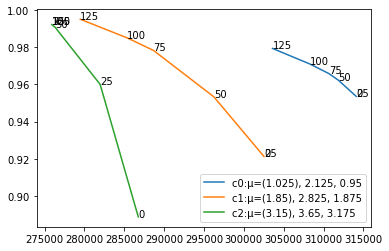

In [ ]:
# draw the various curves X=Profit, Y=IFR while varying Missed Sale Penalty
x=np.vectorize(lambda mm:mm.Results["AverageProfit"])(masterModels)
y=np.vectorize(lambda mm:mm.Results["ItemFillRate"])(masterModels)

import matplotlib.pyplot as plt
for c in range(0, len(masterModels)):
    plt.plot(x[c],
             y[c], label=f'c{c}:µ=({np.mean([len(s["DisruptionSupplier"]) for s in masterModels[c][0].Scenarios])}), '
                          f'{np.mean([len(s["DisruptionPlant"]) for s in masterModels[c][0].Scenarios])}, '
                          f'{np.mean([len(s["DisruptionDC"]) for s in masterModels[c][0].Scenarios])}')
    for p in range(0, len(x[c])):
        plt.text(x[c][p], y[c][p], masterModels[c][p].MissedSalePenalty)
plt.legend()